In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 32
n_classes = 10

train_transforms = [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
train_dataset = ImageFolder('data/cifar10/train', transform = transforms.Compose(train_transforms))
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 8)

test_transforms = [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
test_dataset = ImageFolder('data/cifar10/test', transform = transforms.Compose(test_transforms))
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, num_workers = 8)

Class: 2


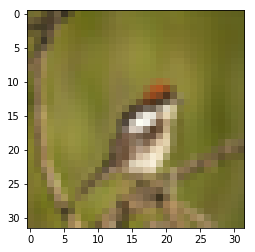

In [3]:
def visualizeFirstFromBatch(imgs):
    img = imgs[0].detach().cpu()
    plt.imshow(img.permute(1,2,0))
    plt.show()

def visualizeOne(dataloader):
    for x,y in dataloader:
        print('Class:', y[0].item())
        visualizeFirstFromBatch(x)
        break

visualizeOne(train_loader)

In [13]:
def trainOneFlatEpoch(model, optimizer, criterion, train_loader, scheduler = None, epoch = 0):
    losses = []
    train_dl = tqdm(train_loader, desc = "Epoch: 0, Loss: 0")
    for x,y in train_dl:
        x,y = x.cuda(), y.cuda()
        x = x.reshape(x.shape[0], -1)

        predictions = model(x)
        loss = criterion(predictions, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None: scheduler.step()

        losses.append(loss.item())
        train_dl.set_description(f'Epoch: {epoch}, Loss: {loss.item():.3f}')
    return losses

def evalFlatModel(model, criterion, test_loader, epoch = 0):
    losses = []
    accs = []    
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.cuda(), y.cuda()
            x = x.reshape(x.shape[0], -1)
            
            predictions = model(x)
            loss = criterion(predictions, y)
            rounded_predictions = torch.argmax(predictions, dim = 1)
            acc = torch.sum(rounded_predictions == y).type(torch.float64) / len(rounded_predictions)
            
            losses.append(loss.item())
            accs.append(acc.item())
            
    print(f'Epoch {epoch} | Validation Loss: {np.mean(losses)} | Validation Accuracy: {np.mean(accs)}')
    
    return np.mean(losses), np.mean(accs)

In [14]:
model = nn.Linear(IMG_SIZE ** 2 * 3, n_classes).cuda()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = None


EPOCHS = 5
losses = []
val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    losses = losses + trainOneFlatEpoch(model, optimizer, criterion, train_loader, epoch = epoch)
    loss, acc = evalFlatModel(model, criterion, test_loader, epoch = epoch)
    val_losses.append(loss)
    val_accs.append(acc)

Epoch: 0, Loss: 0:   0%|          | 0/391 [00:00<?, ?it/s]

 Epoch 0 | Validation Loss: 1.8957896262784548 | Validation Accuracy: 0.3422666139240506


Epoch: 0, Loss: 0:   0%|          | 0/391 [00:00<?, ?it/s]

 Epoch 1 | Validation Loss: 1.8738395911228807 | Validation Accuracy: 0.33969541139240506


Epoch: 2, Loss: 1.648: 100%|██████████| 391/391 [00:04<00:00, 91.50it/s] 


 Epoch 2 | Validation Loss: 1.845646066001699 | Validation Accuracy: 0.3467167721518987
